In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader
from dataset import HMS_Dataset

In [2]:
# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}
max_epochs = 100

In [3]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
print(device)

cuda:0


In [4]:
# Training data
training_set = HMS_Dataset(mode=0)
training_generator = DataLoader(training_set, **params)
print(f'Training set size: {len(training_set)}')

# Test data
test_set = HMS_Dataset(mode=1)
test_generator = DataLoader(test_set, **params)
print(f'Test set size: {len(test_set)}')
# X_test, y_test = test_generator

Training set size: 85440
Test set size: 21360


In [5]:
eeg, spec, label = next(iter(training_set))
print(eeg.shape)
print(spec.shape)
print(label.shape)

(10000, 20)
(300, 401)
(6,)


In [6]:
# # Get distribution of labels
# def get_class_distribution(dataset_obj):
#     count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
#     for element in dataset_obj:
#         y_lbl = element[1]
#         y_lbl = idx2class[y_lbl]
#         count_dict[y_lbl] += 1
            
#     return count_dict

In [7]:
class Multiclass(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.hidden_0 = nn.Linear(200000, 800)
        self.relu = nn.ReLU()
        self.hidden_1 = nn.Linear(800, 800)
        self.hidden_2 = nn.Linear(800, 6)
        self.output = nn.Softmax(dim=0)

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden_0(x)
        x = self.relu(x)
        x = self.hidden_1(x)
        x = self.relu(x)
        x = self.hidden_2(x)
        x = self.output(x)
        return x

In [8]:
# loss metric and optimizer
model = Multiclass().to(device)
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.KLDivLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# prepare model and training parameters
n_epochs = 3

best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

In [9]:
print(model)

Multiclass(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden_0): Linear(in_features=200000, out_features=800, bias=True)
  (relu): ReLU()
  (hidden_1): Linear(in_features=800, out_features=800, bias=True)
  (hidden_2): Linear(in_features=800, out_features=6, bias=True)
  (output): Softmax(dim=0)
)


In [10]:
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm(training_generator, unit="batch") as tepoch:
        for local_batch, spec, local_labels in tepoch:
            X_batch, y_batch = local_batch.to(device), local_labels.to(device)
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            tepoch.set_description(f'Epoch: {epoch}, Accuracy: {epoch_acc[-1]*100:.1f}%')
           
    # set model in evaluation mode and run through the test set
    model.eval()
    with tqdm(test_generator, unit="batch") as tepoch:
        for X_test, spec, y_test in tepoch:
            tepoch.set_description(f'Epoch: {epoch}')
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_pred = model(X_test)
            ce = loss_fn(y_pred, y_test)
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
            ce = float(ce)
            acc = float(acc)
            train_loss_hist.append(np.mean(epoch_loss))
            train_acc_hist.append(np.mean(epoch_acc))
            test_loss_hist.append(ce)
            test_acc_hist.append(acc)
            if acc > best_acc:
                best_acc = acc
                best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Accuracy={best_acc*100:.1f}%")

# Restore best model
model.load_state_dict(best_weights)

  0%|          | 0/1335 [00:00<?, ?batch/s]/home/abram/.local/lib/python3.10/site-packages/torch/nn/functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
Epoch: 0: 100%|██████████| 334/334 [02:03<00:00,  2.70batch/s]


Epoch 0 validation: Accuracy=32.8%


Epoch: 1: 100%|██████████| 334/334 [02:02<00:00,  2.73batch/s]


Epoch 1 validation: Accuracy=34.4%


Epoch: 2: 100%|██████████| 334/334 [02:03<00:00,  2.71batch/s]


Epoch 2 validation: Accuracy=34.4%


<All keys matched successfully>

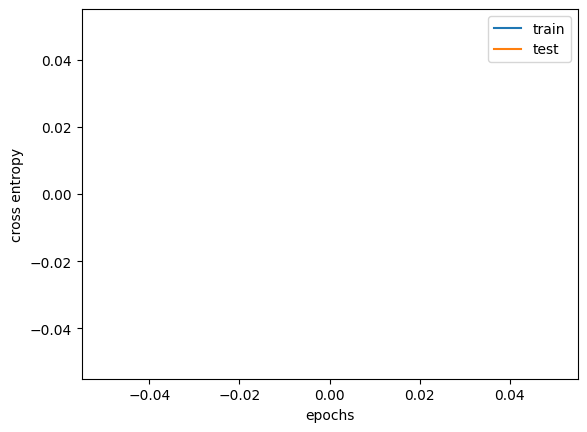

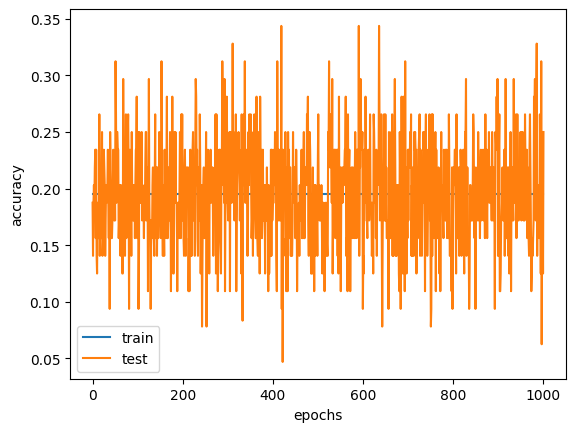

In [11]:
# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()